In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Read The Data

In [13]:
message_file_path = "/home/arnabdey/Placement_ML_projects/My Codes/Microsoft Level 1/MSFT_2012-06-21_34200000_57600000_message_1.csv"
message_df = pd.read_csv(message_file_path, header=None)
message_df.columns = ['time', 'type', 'order_id', 'size', 'price', 'direction']
print(message_df.head())

           time  type  order_id  size   price  direction
0  34200.039884     5         0   300  309600         -1
1  34200.039884     5         0    27  309700         -1
2  34200.074389     1  16135101   300  309500          1
3  34200.201883     1  16166153   100  309700         -1
4  34200.201990     1  16166187   100  309700         -1


In [14]:
orderbook_file_path = "/home/arnabdey/Placement_ML_projects/My Codes/Microsoft Level 1/MSFT_2012-06-21_34200000_57600000_orderbook_1.csv"
orderbook_df = pd.read_csv(orderbook_file_path, header = None)
orderbook_df.columns = ['ask_price_1', 'ask_size_1', 'bid_price_1', 'bid_size_1']
print(orderbook_df.head())

   ask_price_1  ask_size_1  bid_price_1  bid_size_1
0       309900        3788       309500         300
1       309900        3788       309500         300
2       309900        3788       309500         600
3       309700         100       309500         600
4       309700         200       309500         600


# Change to Input Features

In [15]:
orderbook_df['ask_price_1'] = orderbook_df['ask_price_1'] / 1e4
orderbook_df['bid_price_1'] = orderbook_df['bid_price_1'] / 1e4
mid_price = (orderbook_df['ask_price_1'] + orderbook_df['bid_price_1']) / 2.0
spread = orderbook_df['ask_price_1'] - orderbook_df['bid_price_1']
imbalance = (orderbook_df['bid_size_1'] - orderbook_df['ask_size_1']) / (orderbook_df['bid_size_1'] + orderbook_df['ask_size_1'])

In [16]:
N = 10
returns = mid_price.shift(-N) - mid_price
future_direction = (returns > 0).astype(int)
features = pd.DataFrame({
    'mid_price' : mid_price,
    'spread' : spread,
    'imbalance' : imbalance,
    'future_direction' : future_direction
}).dropna()

Using K-means and GMM

In [17]:
X = features[['mid_price', 'spread', 'imbalance']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5) #My PD room number 169
gmm = GaussianMixture(n_components=5)
pca = PCA(n_components=2)
proj = pca.fit_transform(X_scaled)

clusters = kmeans.fit_predict(X_scaled)
gmm_labels = gmm.fit_predict(X_scaled)
features['kmeans_cluster'] = clusters
features['gmm_cluster'] = gmm_labels

/home/arnabdey/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


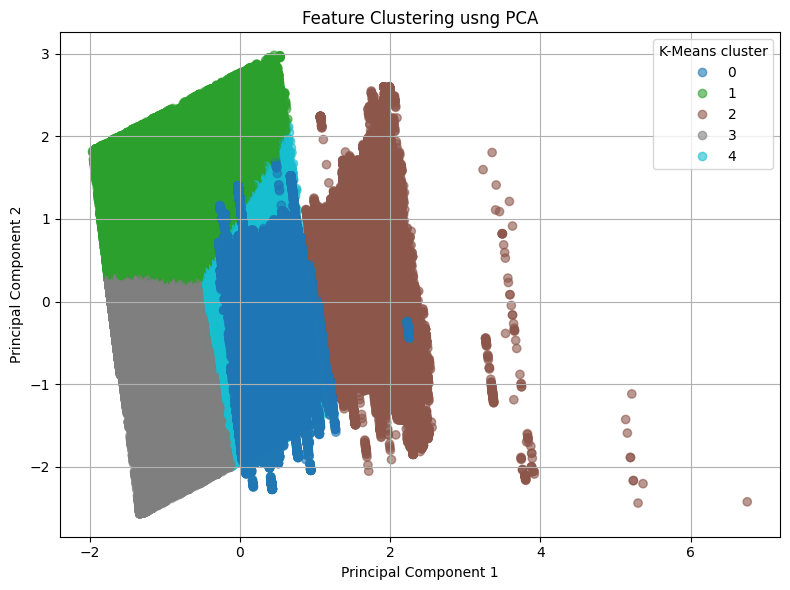

In [18]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(proj[:,0], proj[:,1], c=features['kmeans_cluster'], cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="K-Means cluster")
plt.title("Feature Clustering usng PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

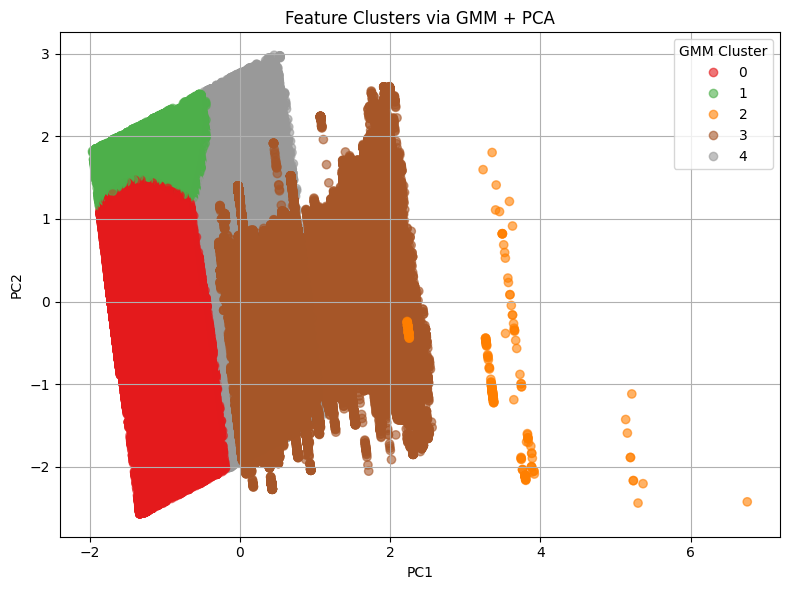

In [19]:
# Project GMM clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=features['gmm_cluster'], cmap='Set1', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="GMM Cluster")
plt.title("Feature Clusters via GMM + PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
encoder = OneHotEncoder(sparse_output=False)
cluster_onehot = encoder.fit_transform(features[['kmeans_cluster']])

X_final = np.hstack((X_scaled, cluster_onehot))
y_final = features['future_direction'].values

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2)
print("Train shape :", X_train.shape, "\nTest shape :", X_test.shape)


Train shape : (329127, 8) 
Test shape : (82282, 8)


In [22]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     78860
           1       0.48      0.40      0.43      3422

    accuracy                           0.96     82282
   macro avg       0.73      0.69      0.71     82282
weighted avg       0.95      0.96      0.96     82282



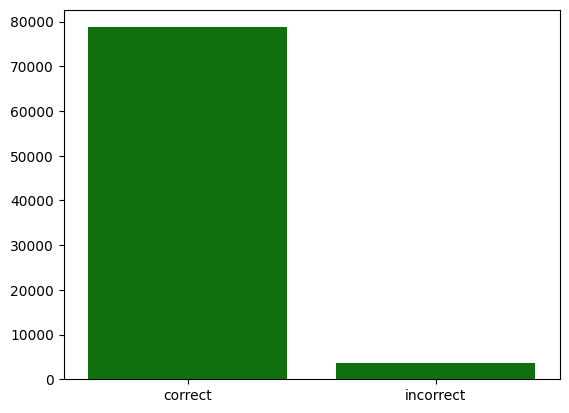

In [23]:
correct = np.count_nonzero(np.array(y_pred==y_test, dtype=int))
incorrect = y_pred.shape[0] - correct
sns.barplot(x=['correct', 'incorrect'], y=[correct, incorrect], color='green')
plt.show()

# Using RBF Neural Network

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

torch.set_float32_matmul_precision('high')

In [25]:
class SpecialRBFLayer(nn.Module):
    def __init__(self, input_dim, output_dim, beta):
        super(SpecialRBFLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.beta = beta

        self.centres = nn.Parameter(torch.randn(output_dim, input_dim))
    def forward(self, x):
        x = x.unsqueeze(1)
        c = self.centres.unsqueeze(0)
        d = torch.norm(x - c, dim=2)
        return torch.exp(-self.beta * (d**2))

In [40]:
class RBFNetwork(nn.Module):
    def __init__(self, input_dim, rbf_dim, beta = 1.0):
        super(RBFNetwork, self).__init__()

        self.rbf = SpecialRBFLayer(input_dim=input_dim, output_dim=rbf_dim, beta=beta)
        self.fc = nn.Linear(in_features=rbf_dim, out_features=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.rbf(x)
        x = self.fc(x)
        out = self.sigmoid(x)
        return out

In [ ]:
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, y_train.unsqueeze(1))
test_dataset = TensorDataset(X_test, y_test.unsqueeze(1))

In [28]:
Train_DataLoader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
Test_DataLoader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [32]:
print(X_train.shape)

torch.Size([329127, 8])


In [45]:
myRBFNet = RBFNetwork(input_dim=X_train.shape[1], rbf_dim=10, beta=0.5)
myRBFNet = torch.compile(myRBFNet).to('cuda')

criterion = nn.BCELoss()
optimizer = optim.AdamW(params=myRBFNet.parameters(), lr=1e-4)

In [42]:
num_epochs = 100

In [46]:
Losses = []
for epoch in tqdm(range(num_epochs)):
    
    per_epoch_loss = 0.0

    for x, y in Train_DataLoader:
        optimizer.zero_grad()
        x, y = x.to('cuda'), y.to('cuda')
        predictions = myRBFNet(x)
        loss = criterion(predictions, y)
        per_epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    Losses.append(per_epoch_loss)

100%|██████████| 100/100 [07:01<00:00,  4.21s/it]


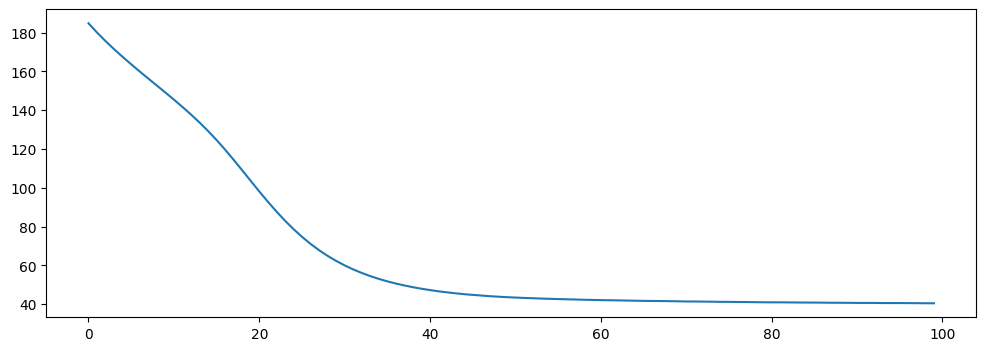

In [49]:
plt.figure(figsize=(12, 4))
plt.plot(Losses)
plt.show()

In [51]:
with torch.no_grad():
    predictions = myRBFNet(X_test.to('cuda')).cpu()
    predicted_classes = (predictions > 0.5).int().squeeze().numpy()
report = classification_report(y_test.numpy(), predicted_classes)

/home/arnabdey/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arnabdey/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arnabdey/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
print(report)

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     78860
         1.0       0.00      0.00      0.00      3422

    accuracy                           0.96     82282
   macro avg       0.48      0.50      0.49     82282
weighted avg       0.92      0.96      0.94     82282

